In [6]:
import cv2
import pandas as pd
import numpy as np
from skimage import io
import sys  
cv2.__version__

'4.5.5'

In [18]:
import os, random
#normalization open cv
random_face_group = []
num_picks = 2000
for i in range(num_picks):
    face_str = random.choice(os.listdir('UTKFace'))
    face_str_split = face_str.split('_')
    if(face_str_split[1]=='0'):
        gender = 'male'
    else:
        gender = 'female'
    
    #set race
    if face_str_split[2]=='0':
        race='white'
    elif face_str_split[2]=='1':
        race = 'black'
    elif face_str_split[2]=='2':
        race='asian'
    elif face_str_split[2]=='3':
        race='indian'
    else:
        race='other'
    face_dict = {'gender':gender,'race':race,'path':face_str}
    random_face_group.append(face_dict)

random_face_group

[{'gender': 'male',
  'race': 'white',
  'path': '6_0_0_20170110224301470.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '40_1_0_20170117091853557.jpg.chip.jpg'},
 {'gender': 'male',
  'race': 'asian',
  'path': '1_0_2_20161219190110523.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'other',
  'path': '21_1_4_20170103223208902.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'indian',
  'path': '2_1_3_20161219225500961.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'indian',
  'path': '26_1_3_20170104235102538.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '32_1_0_20170113210605443.jpg.chip.jpg'},
 {'gender': 'male',
  'race': 'white',
  'path': '54_0_0_20170117163733561.jpg.chip.jpg'},
 {'gender': 'male',
  'race': 'black',
  'path': '54_0_1_20170117142808120.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '84_1_0_20170120222457967.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '75_1_0_20170120230326690.jp

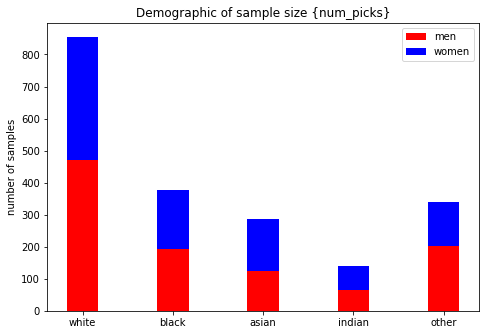

In [19]:
import matplotlib.pyplot as plt

##0: white, 1: black, 2: Asian, 3: Indian, 4: other
men = [0,0,0,0,0]
women = [0,0,0,0,0]
racial_categories = ['white','black','asian','indian','other']

for person in random_face_group:
    race_val = 4
    if person['race']==racial_categories[0]:
        race_val = 0
    elif person['race']==racial_categories[1]:
        race_val = 1
    elif person['race']==racial_categories[2]:
        race_val = 2
    elif person['race']==racial_categories[4]:
        race_val = 3
    
    if person['gender']=='female':
        women[race_val]+=1
    elif person['gender']=='male':
        men[race_val]+=1

num_races = len(racial_categories)
width = 0.35

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ind = np.arange(num_races)

ax.bar(ind,men,width, color='r')
ax.bar(ind,women,width,bottom=men,color='b')
ax.set_ylabel("number of samples")
title = 'Demographic of sample size {num_picks}'
ax.set_title(title)
ax.set_xticks(ind,racial_categories)
ax.legend(['men','women'])

plt.show()

In [37]:
from matplotlib import image
face_df = pd.DataFrame.from_dict(random_face_group)

img_data = {x:0 for x in range(len(face_df))}
for idx, row in face_df.iterrows():
    relative_path = 'UTKFace\\'+str(row["path"])
    img = image.imread(relative_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_data[idx] = gray


face_df['img_data'] = pd.Series(img_data)
face_df


,gender,race,path,img_data
0,male,white,6_0_0_20170110224301470.jpg.chip.jpg,"[[165, 166, 166, 164, 163, 163, 164, 167, 176,..."
1,female,white,40_1_0_20170117091853557.jpg.chip.jpg,"[[59, 59, 59, 59, 61, 69, 80, 89, 97, 109, 116..."
2,male,asian,1_0_2_20161219190110523.jpg.chip.jpg,"[[236, 236, 236, 235, 235, 234, 234, 234, 235,..."
3,female,other,21_1_4_20170103223208902.jpg.chip.jpg,"[[11, 13, 15, 19, 23, 25, 28, 29, 37, 41, 50, ..."
4,female,indian,2_1_3_20161219225500961.jpg.chip.jpg,"[[239, 241, 243, 244, 245, 244, 245, 246, 244,..."
...,...,...,...,...
1995,male,white,80_0_0_20170111200927317.jpg.chip.jpg,"[[255, 255, 255, 254, 254, 253, 253, 253, 254,..."
1996,male,black,26_0_1_20170114032944348.jpg.chip.jpg,"[[125, 126, 127, 129, 131, 131, 131, 131, 134,..."
1997,female,black,46_1_1_20170116001421842.jpg.chip.jpg,"[[0, 0, 2, 2, 0, 0, 1, 1, 1, 4, 10, 15, 17, 18..."
1998,male,indian,29_0_3_20170119195312988.jpg.chip.jpg,"[[26, 29, 29, 26, 25, 26, 25, 21, 18, 17, 16, ..."


In [ ]:
from sklearn.decomposition import PCA

def get_eigenface(sample_idx, x, max_coef=10):
    """ plots estimates of original image from pca compression
    
    Args:
        sample_idx (int): which image to work with
        x (np.array): (n_sample, n_feat) original image data
        max_coef (int): maximum pca coefficient to represent
    """
    
    
    # the default n_components will have PCA build as 
    # many compnents as there are features.  this is preferred
    # here as we can use our limit_coef param as needed
    pca = PCA()

    # compress all faces to lower dimensional representation
    face_data_compress = pca.fit_transform(face_data)
    
    for limit_coef in range(max_coef):
        # estimate original image
        x_compress = face_data_compress[sample_idx, :]
        x_pred = inverse_transform(x_compress, pca, limit_coef=limit_coef)
        
        # compute compression ratio stats
        n_compress = limit_coef + 1
        n = x_pred.size
        p = n_compress / n
        
        # plot this estimate
        plt.figure()
        plot_face(x_pred)
        title = f'{n_compress} of {n} features ({p:.3f} of memory)'
        plt.suptitle(title)